In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from sklearn import preprocessing
import zipfile
import shutil
from sklearn.preprocessing import StandardScaler
import math
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def fit_data(data_list, fit=True):
    a,b,c,d = data_list[0].shape
    all_data = []
    for data in data_list:
        new_data = data.reshape(-1)
        all_data.append(new_data)
    all_data = np.stack(all_data,1)
    print(all_data.shape)
    if fit:
        standardScaler.fit(all_data)
        print("fit train data")
    all_data = standardScaler.transform(all_data)
    res_data = []
    for i in range(all_data.shape[1]):
        data = all_data[:,i].reshape(a,b,c,d)
        res_data.append(data)
    return res_data

In [5]:
def load_data():
    
    # CMIP data       
    cmip_sst = torch.load("cmip_sst_data.pt")  ## 56156, 12, 24, 72
    cmip_t300 = torch.load("cmip_t300_data.pt")
    cmip_ua = torch.load("cmip_ua_data.pt")
    cmip_va = torch.load("cmip_va_data.pt")
    cmip_label = torch.load("cmip_label.pt")

    # SODA data    
    soda_data = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_train.nc')
    soda_label = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_label.nc')
    
    soda_sst = soda_data['sst'][:, :12].values.astype('float32')  # (100, 12, 24, 72)
    soda_t300 = soda_data['t300'][:, :12].values.astype('float32')
    soda_ua = soda_data['ua'][:, :12].values.astype('float32')
    soda_va = soda_data['va'][:, :12].values.astype('float32')
    soda_label = soda_label['nino'][:, 12:36].values.astype('float32')
    
    soda_sst = np.nan_to_num(soda_sst) # trans nan to 0
    soda_t300 = np.nan_to_num(soda_t300)
    soda_ua = np.nan_to_num(soda_ua)
    soda_va = np.nan_to_num(soda_va)

    dict_cmip = {
        'sst':cmip_sst,
        't300':cmip_t300,
        'ua':cmip_ua,
        'va': cmip_va,
        'label': cmip_label}
    dict_soda = {
        'sst':soda_sst,
        't300':soda_t300,
        'ua':soda_ua,
        'va': soda_va,
        'label': soda_label}
    
    cmip_dataset = EarthDataSet(dict_cmip)
    soda_dataset = EarthDataSet(dict_soda)
    
    train_1, valid_1 = random_split(cmip_dataset, [4545, 100])
    train_2, valid_2 = random_split(soda_dataset, [0, 100])
    
    train_dataset = train_1 + valid_2 + valid_2 + valid_2 + valid_2
    valid_dataset = valid_1
    valid_dataset_2 = valid_2
    
    print('Train samples: {}, Valid1 samples: {}, Valid2 samples: {}'.format(len(train_dataset), len(valid_dataset), len(valid_dataset_2)))
    
    return train_dataset, valid_dataset, valid_dataset_2

In [6]:
set_seed()
standardScaler = StandardScaler()
train_dataset, valid_dataset, valid_dataset_2 = load_data()      
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
valid_loader_2 = DataLoader(valid_dataset_2, batch_size=32, shuffle=False)

Train samples: 4945, Valid1 samples: 100, Valid2 samples: 100


In [7]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def train(num_epochs):
    best_score = -99
    loss_epoch = []
    score_epoch = []
    score_epoch_2 = []
    epoch = -1
    model.eval()
    y_true, y_pred = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred.append(preds.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    x_month = np.arange(24)
    score = eval_score(y_true, y_pred)
    best_score = score
    
    y_true_2, y_pred_2 = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader_2):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred_2.append(preds.cpu().detach().numpy())
        y_true_2.append(label.cpu().detach().numpy())

    y_true_2 = np.concatenate(y_true_2, axis=0)
    y_pred_2 = np.concatenate(y_pred_2, axis=0)
    x_month = np.arange(24)
    score_2 = eval_score(y_true_2, y_pred_2)
    print('Epoch: {}, Valid Score: {}, Valid Score 2: {}\n'.format(epoch+1,score,score_2))    
        
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):   
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%20 == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))
        loss_epoch.append(np.mean(all_loss))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds.cpu().detach().numpy())
            y_true.append(label.cpu().detach().numpy())

        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        score_epoch.append(score)
        
        y_true_2, y_pred_2 = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader_2):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred_2.append(preds.cpu().detach().numpy())
            y_true_2.append(label.cpu().detach().numpy())

        y_true_2 = np.concatenate(y_true_2, axis=0)
        y_pred_2 = np.concatenate(y_pred_2, axis=0)
        x_month = np.arange(24)
        score_2 = eval_score(y_true_2, y_pred_2)
        score_epoch_2.append(score_2)
        print('Epoch: {}, Valid Score: {}, Valid Score 2: {}\n'.format(epoch+1,score,score_2))    
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(10):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        for i in range(10, 23):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true_2[i],color='red')
            plt.plot(x_month, y_pred_2[i],color='blue')
        plt.subplot(5,5,24)
        plt.plot(np.arange(len(loss_epoch))[:20],loss_epoch[-20:])
        plt.subplot(5,5,25)
        plt.plot(np.arange(len(score_epoch)),score_epoch)
        plt.plot(np.arange(len(score_epoch)),score_epoch_2)
        plt.tight_layout()
        plt.show()
        
    max_score = max(score_epoch)
    max_epoch = score_epoch.index(max_score) + 1
    print("max score: {} at eopch {}".format(max_score, max_epoch))
    max_score_2 = max(score_epoch_2)
    max_epoch_2 = score_epoch_2.index(max_score_2) + 1
    print("max score 2: {} at eopch {}".format(max_score_2, max_epoch_2))

In [10]:
def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

In [11]:
def gelu(x):
    """ Original Implementation of the gelu activation function in Google Bert repo when initialy created.
        For information: OpenAI GPT's gelu is slightly different (and gives slightly different results):
        0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
        Also see https://arxiv.org/abs/1606.08415
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=gelu, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
    
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.mat = torch.matmul

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (self.mat(q, k.transpose(-2, -1))) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = self.mat(attn, v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
    
class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, proj_drop=0., attn_drop=0.,
                 drop_path=0., act_layer=gelu, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=proj_drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
#         self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=proj_drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


In [12]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()

#         resnet = models.resnet18()
#         resnet.conv1 = nn.Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), padding=(2, 4), bias=False)
#         resnet.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
#         self.cnn = nn.Sequential(*(list(resnet.children())[:-1]))
        
        self.cnn = nn.Sequential(nn.Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), bias=False),
                                   nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(64, 128, kernel_size=(4, 8), stride=(1, 1), bias=False),
                                   nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(128, 256, kernel_size=(4, 8), stride=(1, 1), bias=False),
                                   nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
                                   nn.ReLU(inplace=True),
                                   nn.AdaptiveAvgPool2d(1))
        
        embed_dim = 256
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 13, embed_dim))
        
        self.block = nn.Sequential(Block(dim=embed_dim, num_heads=8),
                                   Block(dim=embed_dim, num_heads=8),
                                   Block(dim=embed_dim, num_heads=8),)
        
        self.norm = nn.LayerNorm(embed_dim)
        
        # Classifier head
        self.linear = nn.Linear(embed_dim, 64)
        self.tanh = nn.Tanh()
        self.head = nn.Linear(64, 24)
    
        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        
    def forward_features(self, x):
        bs = x.shape[0]
        cls_tokens = self.cls_token.expand(bs, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.block(x)
        x = self.norm(x)
        
        return x[:,0]

    def forward(self, sst, t300, ua, va):
        x = torch.stack([sst, t300, ua, va], dim=2) # b * 12 * 4 * 24 * 72
        bs = x.shape[0]
        seq = []
        for t in range(x.shape[1]):
            t_i = x[:,t,:,:,:] # b * 4 * 24 * 72
            t_i = self.cnn(t_i).view(bs, -1)  # b * 512
#             t_i = self.embed(t_i)
            seq.append(t_i)
        x = torch.stack(seq, dim=1) # b * 12 * 512
        x = self.forward_features(x)
        x = self.linear(x)
        x = self.tanh(x)
        x = self.head(x)  # b * 24
    
        return x

In [13]:
'''



'''

'\n\n\n\n'

In [14]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=8e-5)
loss_fn = nn.MSELoss()

gpu_ids = [i for i in range(int(torch.cuda.device_count()))]
model = torch.nn.DataParallel(model.to("cuda:0"), device_ids=gpu_ids)
loss_fn = loss_fn.to(device)

In [15]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

DataParallel : all params: 3.708888M


In [16]:
model

DataParallel(
  (module): CNN_Model(
    (cnn): Sequential(
      (0): Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(4, 8), stride=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 256, kernel_size=(4, 8), stride=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): AdaptiveAvgPool2d(output_size=1)
    )
    (block): Sequential(
      (0): Block(
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=256, out_features=768, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=25

acskill_socre:-5.894510995454163, rmse_score:20.856069906652735
acskill_socre:-0.2468308309807264, rmse_score:20.058609993011565
Epoch: 0, Valid Score: -26.750580902106897, Valid Score 2: -20.305440823992292

Step: 0, Train Loss: 0.741368293762207
Step: 20, Train Loss: 0.7745534777641296
Step: 40, Train Loss: 0.6217968463897705
Step: 60, Train Loss: 0.6332364082336426
Step: 80, Train Loss: 0.7096325755119324
Step: 100, Train Loss: 0.6186847686767578
Step: 120, Train Loss: 0.4882797598838806
Step: 140, Train Loss: 0.5558454990386963
Epoch: 1, Train loss: 0.5964673546052748
acskill_socre:46.0778796924075, rmse_score:17.758394547183464
acskill_socre:22.629682939897066, rmse_score:17.803894634429852
Epoch: 1, Valid Score: 28.319485145224036, Valid Score 2: 4.8257883054672135

Model saved successfully


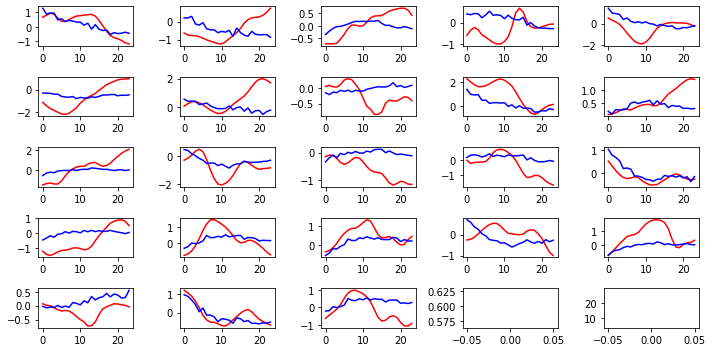

Step: 0, Train Loss: 0.5068910121917725
Step: 20, Train Loss: 0.5112115740776062
Step: 40, Train Loss: 0.47649478912353516
Step: 60, Train Loss: 0.6444620490074158
Step: 80, Train Loss: 0.5746651887893677
Step: 100, Train Loss: 0.5510507822036743
Step: 120, Train Loss: 0.421097993850708
Step: 140, Train Loss: 0.5045590996742249
Epoch: 2, Train loss: 0.5488531495294263
acskill_socre:53.108834847273556, rmse_score:16.6296544629931
acskill_socre:34.70043921441347, rmse_score:17.065192035570316
Epoch: 2, Valid Score: 36.479180384280454, Valid Score 2: 17.635247178843155

Model saved successfully


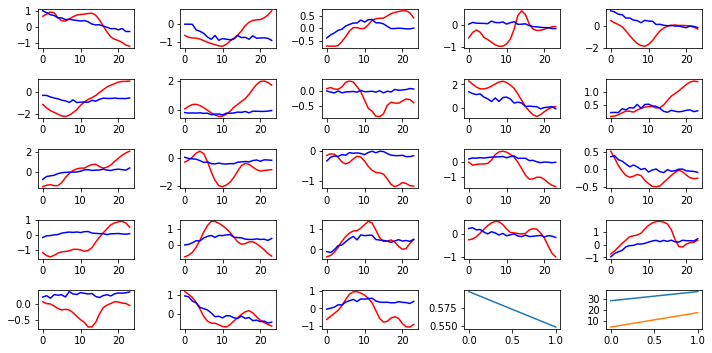

Step: 0, Train Loss: 0.3661063313484192
Step: 20, Train Loss: 0.824505090713501
Step: 40, Train Loss: 0.4779759645462036
Step: 60, Train Loss: 0.4932210445404053
Step: 80, Train Loss: 0.5364772081375122
Step: 100, Train Loss: 0.6321892142295837
Step: 120, Train Loss: 0.5834275484085083
Step: 140, Train Loss: 0.486952543258667
Epoch: 3, Train loss: 0.5211605106630633
acskill_socre:57.07364047548033, rmse_score:16.05729824726689
acskill_socre:29.261752683933345, rmse_score:17.55733426727648
Epoch: 3, Valid Score: 41.016342228213446, Valid Score 2: 11.704418416656864

Model saved successfully


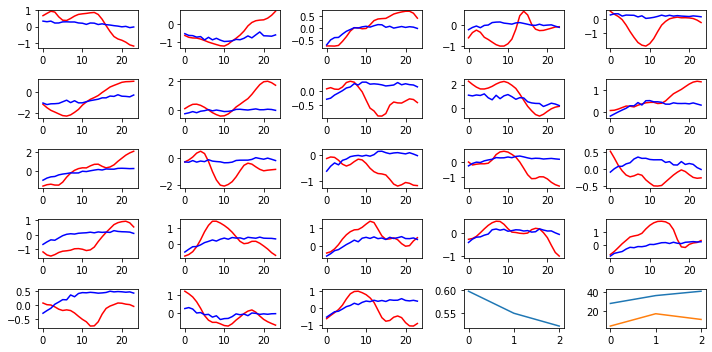

Step: 0, Train Loss: 0.4717119634151459
Step: 20, Train Loss: 0.48669442534446716
Step: 40, Train Loss: 0.6506104469299316
Step: 60, Train Loss: 0.5273886322975159
Step: 80, Train Loss: 0.46126604080200195
Step: 100, Train Loss: 0.44767457246780396
Step: 120, Train Loss: 0.3791660666465759
Step: 140, Train Loss: 0.4351450800895691
Epoch: 4, Train loss: 0.5003286388612562
acskill_socre:52.91126995579478, rmse_score:15.904352587403322
acskill_socre:39.29356277548711, rmse_score:16.329503496103285
Epoch: 4, Valid Score: 37.006917368391456, Valid Score 2: 22.964059279383825



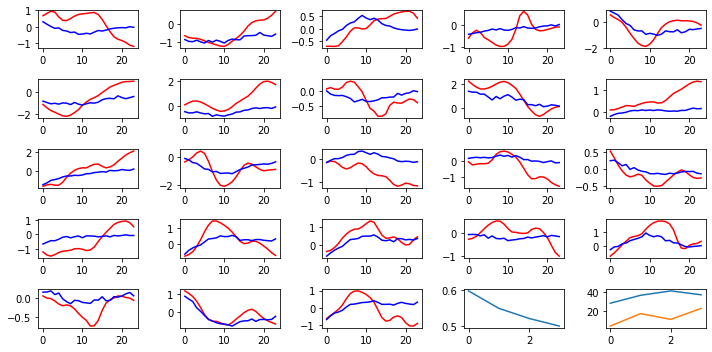

Step: 0, Train Loss: 0.4144063889980316
Step: 20, Train Loss: 0.5554901361465454
Step: 40, Train Loss: 0.428879976272583
Step: 60, Train Loss: 0.5097613334655762
Step: 80, Train Loss: 0.532227635383606
Step: 100, Train Loss: 0.4977667033672333
Step: 120, Train Loss: 0.3835832476615906
Step: 140, Train Loss: 0.5318045020103455
Epoch: 5, Train loss: 0.4761087134961159
acskill_socre:48.41319276756929, rmse_score:17.20368964749587
acskill_socre:53.26299518083611, rmse_score:15.542302511811343
Epoch: 5, Valid Score: 31.20950312007342, Valid Score 2: 37.720692669024764



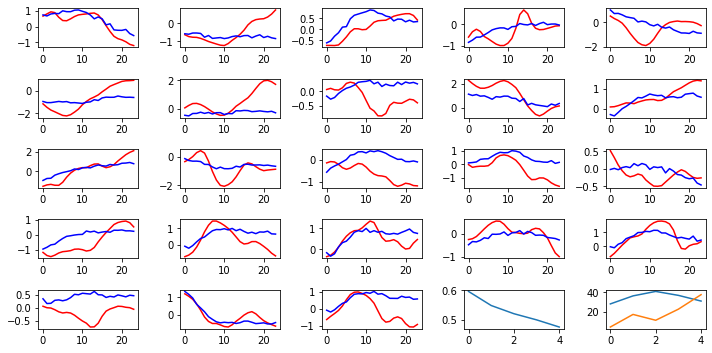

Step: 0, Train Loss: 0.46891090273857117
Step: 20, Train Loss: 0.38590049743652344
Step: 40, Train Loss: 0.7845416069030762
Step: 60, Train Loss: 0.35412585735321045
Step: 80, Train Loss: 0.3675727844238281
Step: 100, Train Loss: 0.5606404542922974
Step: 120, Train Loss: 0.512130856513977
Step: 140, Train Loss: 0.3945627212524414
Epoch: 6, Train loss: 0.4571079861733221
acskill_socre:57.88471466403045, rmse_score:14.918191465467295
acskill_socre:62.13687765975186, rmse_score:14.169537514356428
Epoch: 6, Valid Score: 42.96652319856315, Valid Score 2: 47.96734014539543

Model saved successfully


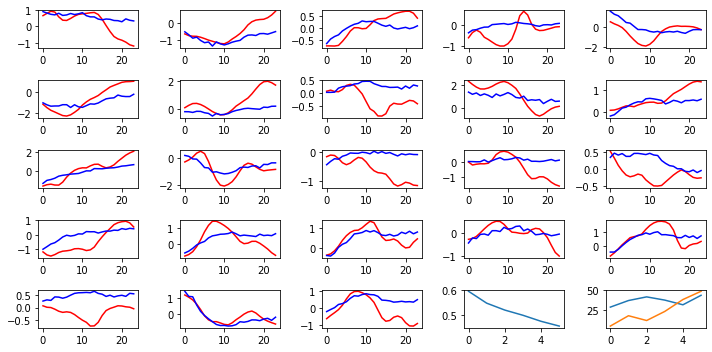

Step: 0, Train Loss: 0.5179785490036011
Step: 20, Train Loss: 0.7027009725570679
Step: 40, Train Loss: 0.3922463357448578
Step: 60, Train Loss: 0.3767659068107605
Step: 80, Train Loss: 0.471616268157959
Step: 100, Train Loss: 0.2928272485733032
Step: 120, Train Loss: 0.4571518898010254
Step: 140, Train Loss: 0.43208107352256775
Epoch: 7, Train loss: 0.4324890536646689
acskill_socre:56.10984055846984, rmse_score:15.380195474223223
acskill_socre:68.86761667875201, rmse_score:13.332319898869294
Epoch: 7, Valid Score: 40.72964508424662, Valid Score 2: 55.53529677988272



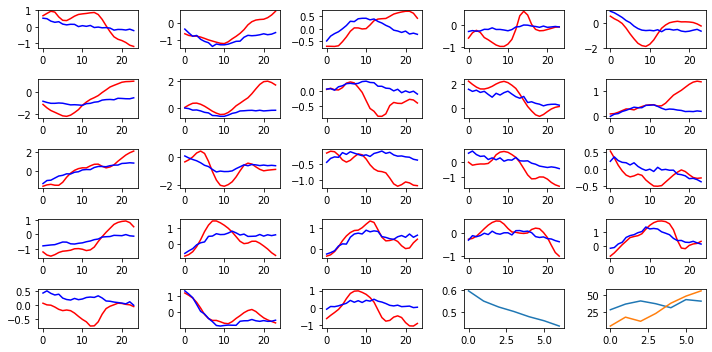

Step: 0, Train Loss: 0.4403139054775238
Step: 20, Train Loss: 0.368335098028183
Step: 40, Train Loss: 0.33270716667175293
Step: 60, Train Loss: 0.3741622567176819
Step: 80, Train Loss: 0.49204182624816895
Step: 100, Train Loss: 0.506531298160553
Step: 120, Train Loss: 0.542901337146759
Step: 140, Train Loss: 0.4296615719795227
Epoch: 8, Train loss: 0.42245897477672945
acskill_socre:60.59241630045811, rmse_score:14.867469708521414
acskill_socre:76.80000360420917, rmse_score:12.297626777901213
Epoch: 8, Valid Score: 45.7249465919367, Valid Score 2: 64.50237682630795

Model saved successfully


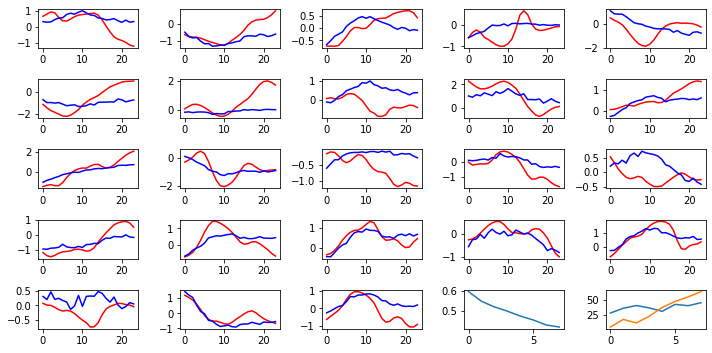

Step: 0, Train Loss: 0.31378209590911865
Step: 20, Train Loss: 0.34803223609924316
Step: 40, Train Loss: 0.35021650791168213
Step: 60, Train Loss: 0.39467284083366394
Step: 80, Train Loss: 0.4024622142314911
Step: 100, Train Loss: 0.41243410110473633
Step: 120, Train Loss: 0.35385748744010925
Step: 140, Train Loss: 0.4231547713279724
Epoch: 9, Train loss: 0.39577311325457787
acskill_socre:63.103485101649554, rmse_score:14.407529363741205
acskill_socre:78.89151883239722, rmse_score:12.796777307374656
Epoch: 9, Valid Score: 48.69595573790835, Valid Score 2: 66.09474152502257

Model saved successfully


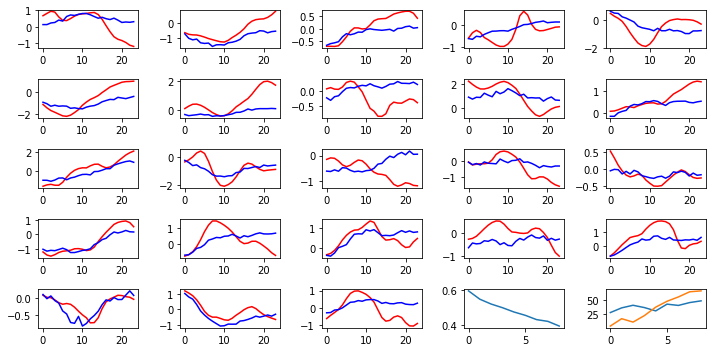

Step: 0, Train Loss: 0.4148100018501282
Step: 20, Train Loss: 0.33791133761405945
Step: 40, Train Loss: 0.3624773621559143
Step: 60, Train Loss: 0.3045405447483063
Step: 80, Train Loss: 0.35861706733703613
Step: 100, Train Loss: 0.3424937129020691
Step: 120, Train Loss: 0.33222031593322754
Step: 140, Train Loss: 0.41975557804107666
Epoch: 10, Train loss: 0.3723547108711735
acskill_socre:57.326701529630995, rmse_score:15.412697884201267
acskill_socre:87.81259305171622, rmse_score:11.119780928120905
Epoch: 10, Valid Score: 41.91400364542973, Valid Score 2: 76.69281212359532



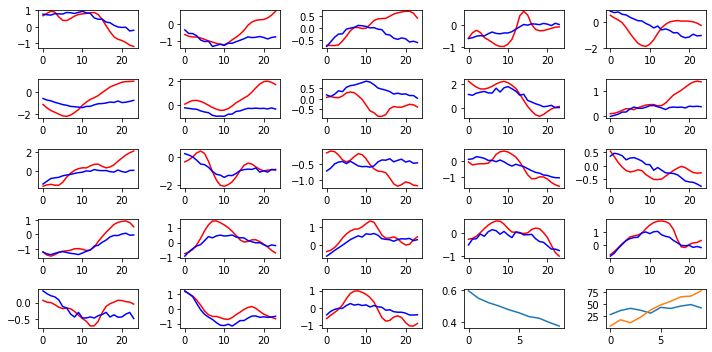

Step: 0, Train Loss: 0.31533151865005493
Step: 20, Train Loss: 0.4700290858745575
Step: 40, Train Loss: 0.2607783079147339
Step: 60, Train Loss: 0.2703685164451599
Step: 80, Train Loss: 0.3435485064983368
Step: 100, Train Loss: 0.3444535732269287
Step: 120, Train Loss: 0.39570626616477966
Step: 140, Train Loss: 0.33966660499572754
Epoch: 11, Train loss: 0.3553216209334712
acskill_socre:60.290349229028266, rmse_score:15.00640307762898
acskill_socre:89.69618188456855, rmse_score:10.137173872543825
Epoch: 11, Valid Score: 45.283946151399284, Valid Score 2: 79.55900801202472



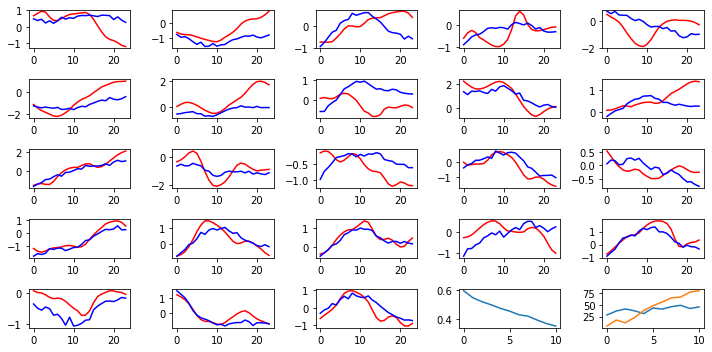

Step: 0, Train Loss: 0.39977478981018066
Step: 20, Train Loss: 0.2946753203868866
Step: 40, Train Loss: 0.2406693398952484
Step: 60, Train Loss: 0.23791837692260742
Step: 80, Train Loss: 0.3520265221595764
Step: 100, Train Loss: 0.34823745489120483
Step: 120, Train Loss: 0.2641719579696655
Step: 140, Train Loss: 0.282071977853775
Epoch: 12, Train loss: 0.3289412297548786
acskill_socre:61.183217800603686, rmse_score:15.047127127750072
acskill_socre:92.00366871606306, rmse_score:9.863837586983601
Epoch: 12, Valid Score: 46.13609067285361, Valid Score 2: 82.13983112907945



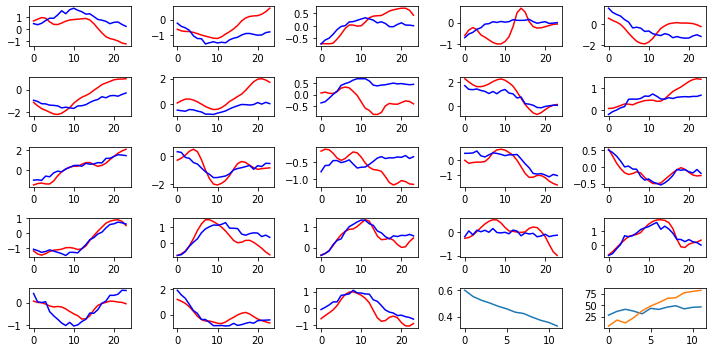

Step: 0, Train Loss: 0.34645265340805054
Step: 20, Train Loss: 0.3369424343109131
Step: 40, Train Loss: 0.29222217202186584
Step: 60, Train Loss: 0.23788993060588837
Step: 80, Train Loss: 0.29200437664985657
Step: 100, Train Loss: 0.4836522042751312
Step: 120, Train Loss: 0.22576867043972015
Step: 140, Train Loss: 0.2389862835407257
Epoch: 13, Train loss: 0.30786295975408245
acskill_socre:54.4374013393934, rmse_score:15.55579873342687
acskill_socre:93.07094276349656, rmse_score:10.150827127690224
Epoch: 13, Valid Score: 38.881602605966535, Valid Score 2: 82.92011563580634



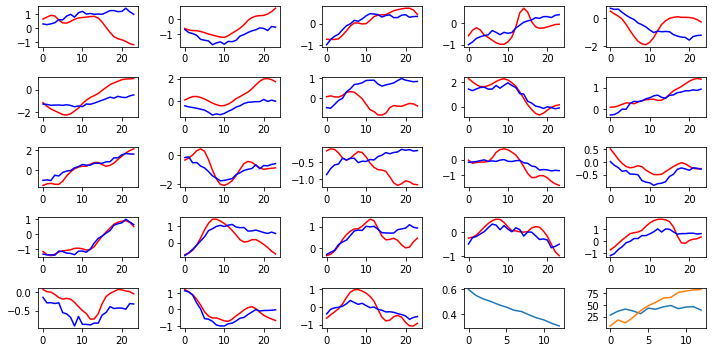

Step: 0, Train Loss: 0.2833273112773895
Step: 20, Train Loss: 0.22707407176494598
Step: 40, Train Loss: 0.23603582382202148
Step: 60, Train Loss: 0.27007508277893066
Step: 80, Train Loss: 0.24794277548789978
Step: 100, Train Loss: 0.3707217872142792
Step: 120, Train Loss: 0.1559121161699295
Step: 140, Train Loss: 0.314586341381073
Epoch: 14, Train loss: 0.2833855940449622
acskill_socre:55.74264726965478, rmse_score:16.328877905674457
acskill_socre:97.17810116831197, rmse_score:8.490558227307933
Epoch: 14, Valid Score: 39.41376936398032, Valid Score 2: 88.68754294100404



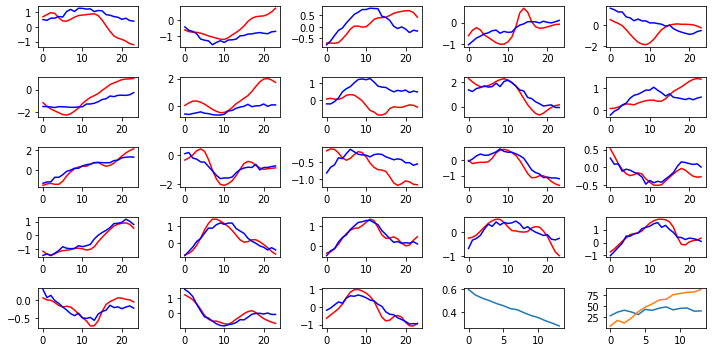

Step: 0, Train Loss: 0.2421303391456604
Step: 20, Train Loss: 0.2849462032318115
Step: 40, Train Loss: 0.20103108882904053
Step: 60, Train Loss: 0.2589395046234131
Step: 80, Train Loss: 0.26949572563171387
Step: 100, Train Loss: 0.2614959478378296
Step: 120, Train Loss: 0.23113548755645752
Step: 140, Train Loss: 0.28806960582733154
Epoch: 15, Train loss: 0.2583410458218667
acskill_socre:49.70504766103148, rmse_score:17.925833224139872
acskill_socre:95.40817370783914, rmse_score:10.29930865682194
Epoch: 15, Valid Score: 31.779214436891607, Valid Score 2: 85.1088650510172



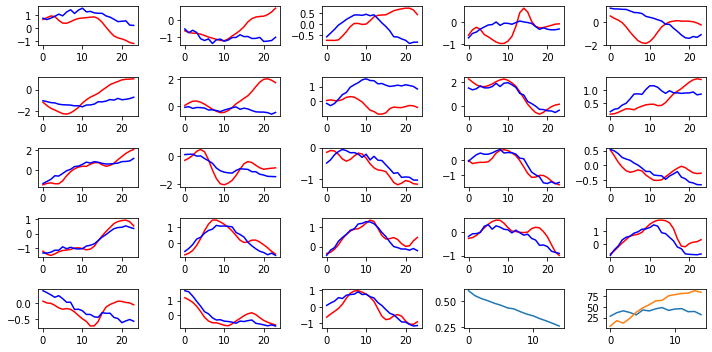

Step: 0, Train Loss: 0.2711344361305237
Step: 20, Train Loss: 0.20140676200389862
Step: 40, Train Loss: 0.25136762857437134
Step: 60, Train Loss: 0.24845831096172333
Step: 80, Train Loss: 0.3149791955947876
Step: 100, Train Loss: 0.25497347116470337
Step: 120, Train Loss: 0.19416043162345886
Step: 140, Train Loss: 0.265544056892395
Epoch: 16, Train loss: 0.23455540893539306
acskill_socre:60.19179217621758, rmse_score:15.958852974051235
acskill_socre:96.46659533754986, rmse_score:10.502037745387526
Epoch: 16, Valid Score: 44.23293920216635, Valid Score 2: 85.96455759216234



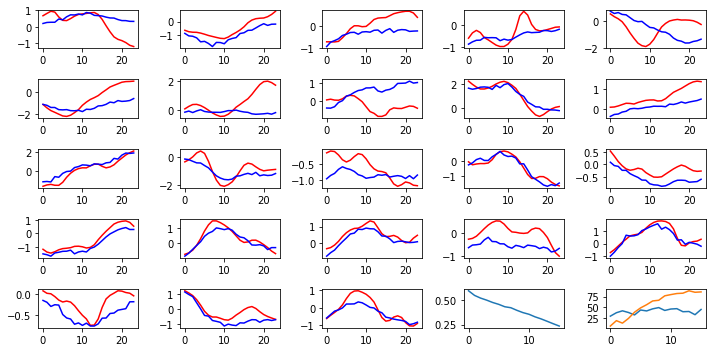

Step: 0, Train Loss: 0.23028871417045593
Step: 20, Train Loss: 0.18878492712974548
Step: 40, Train Loss: 0.18147185444831848
Step: 60, Train Loss: 0.145714670419693
Step: 80, Train Loss: 0.2316882312297821
Step: 100, Train Loss: 0.18112914264202118
Step: 120, Train Loss: 0.2525576949119568
Step: 140, Train Loss: 0.1826218217611313
Epoch: 17, Train loss: 0.21132993496233418
acskill_socre:53.661357069389204, rmse_score:16.313313252068497
acskill_socre:98.73482528178965, rmse_score:8.504544469348017
Epoch: 17, Valid Score: 37.34804381732071, Valid Score 2: 90.23028081244163



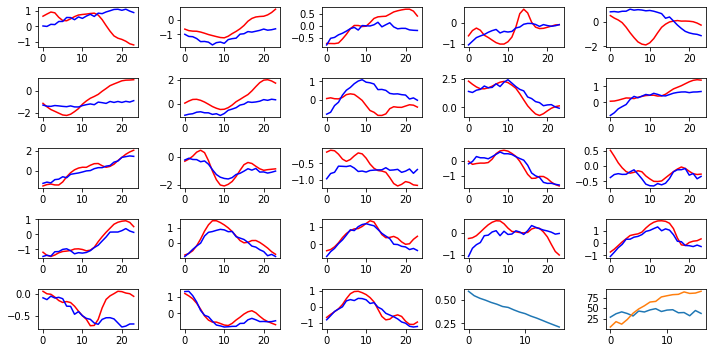

Step: 0, Train Loss: 0.19400739669799805
Step: 20, Train Loss: 0.18091163039207458
Step: 40, Train Loss: 0.16433364152908325
Step: 60, Train Loss: 0.18342599272727966
Step: 80, Train Loss: 0.21662291884422302
Step: 100, Train Loss: 0.20744559168815613
Step: 120, Train Loss: 0.11360673606395721
Step: 140, Train Loss: 0.2274719476699829
Epoch: 18, Train loss: 0.19081246324123874
acskill_socre:55.51279595147112, rmse_score:15.915275408105883
acskill_socre:98.6468849299434, rmse_score:7.580007022167353
Epoch: 18, Valid Score: 39.597520543365235, Valid Score 2: 91.06687790777605



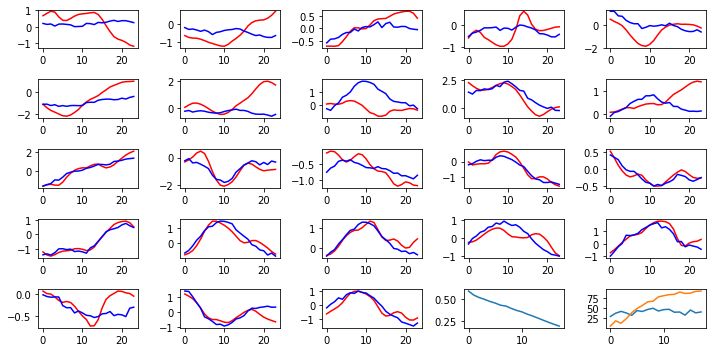

Step: 0, Train Loss: 0.29894694685935974
Step: 20, Train Loss: 0.17302677035331726
Step: 40, Train Loss: 0.12006490677595139
Step: 60, Train Loss: 0.16855037212371826
Step: 80, Train Loss: 0.17663472890853882
Step: 100, Train Loss: 0.1413995623588562
Step: 120, Train Loss: 0.1447897106409073
Step: 140, Train Loss: 0.2898560166358948
Epoch: 19, Train loss: 0.1797038278272075
acskill_socre:55.59643250285592, rmse_score:16.068539026279254
acskill_socre:100.17479936542324, rmse_score:7.231471354999084
Epoch: 19, Valid Score: 39.527893476576665, Valid Score 2: 92.94332801042415



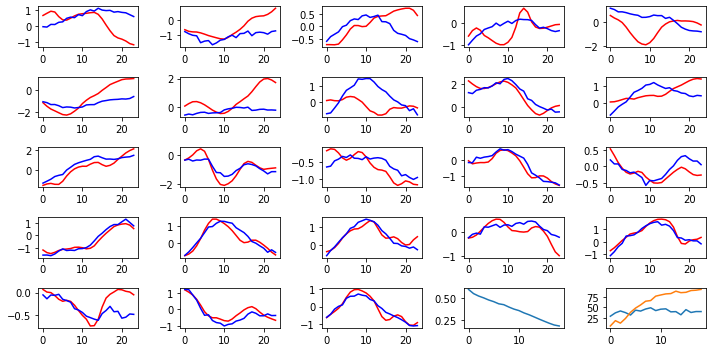

Step: 0, Train Loss: 0.14429140090942383
Step: 20, Train Loss: 0.1527251899242401
Step: 40, Train Loss: 0.15315943956375122
Step: 60, Train Loss: 0.21376600861549377
Step: 80, Train Loss: 0.16778704524040222
Step: 100, Train Loss: 0.20069748163223267
Step: 120, Train Loss: 0.1320846974849701
Step: 140, Train Loss: 0.20786552131175995
Epoch: 20, Train loss: 0.16239911721598718
acskill_socre:53.0536058911288, rmse_score:16.443340276940635
acskill_socre:100.86859831737459, rmse_score:6.838746291988447
Epoch: 20, Valid Score: 36.610265614188165, Valid Score 2: 94.02985202538615



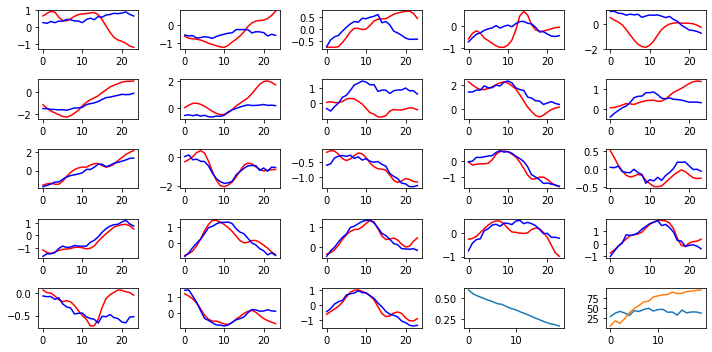

Step: 0, Train Loss: 0.11678792536258698
Step: 20, Train Loss: 0.13572359085083008
Step: 40, Train Loss: 0.15276870131492615
Step: 60, Train Loss: 0.14308631420135498
Step: 80, Train Loss: 0.15269310772418976
Step: 100, Train Loss: 0.12732237577438354
Step: 120, Train Loss: 0.16091854870319366
Step: 140, Train Loss: 0.15726706385612488
Epoch: 21, Train loss: 0.1468842129553518
acskill_socre:53.76152495629543, rmse_score:16.258504113964236
acskill_socre:102.92920617154336, rmse_score:5.965137622323613
Epoch: 21, Valid Score: 37.503020842331196, Valid Score 2: 96.96406854921975



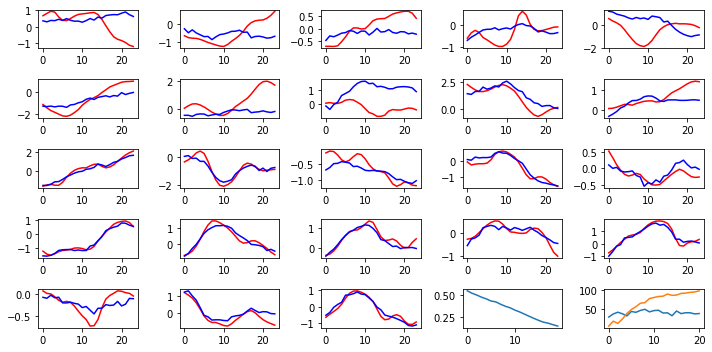

Step: 0, Train Loss: 0.09686088562011719
Step: 20, Train Loss: 0.11778955161571503
Step: 40, Train Loss: 0.15000247955322266
Step: 60, Train Loss: 0.14490382373332977
Step: 80, Train Loss: 0.10114866495132446
Step: 100, Train Loss: 0.11487823724746704
Step: 120, Train Loss: 0.09728163480758667
Step: 140, Train Loss: 0.1267249584197998
Epoch: 22, Train loss: 0.13637577521224176
acskill_socre:55.2626379722295, rmse_score:16.24910229443574
acskill_socre:101.42349382891175, rmse_score:6.927171049249594
Epoch: 22, Valid Score: 39.013535677793755, Valid Score 2: 94.49632277966215



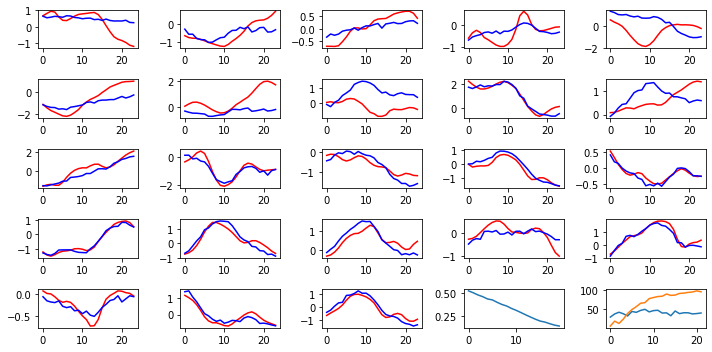

Step: 0, Train Loss: 0.1430547535419464
Step: 20, Train Loss: 0.13697202503681183
Step: 40, Train Loss: 0.11387701332569122
Step: 60, Train Loss: 0.1160699725151062
Step: 80, Train Loss: 0.12719333171844482
Step: 100, Train Loss: 0.11809437721967697
Step: 120, Train Loss: 0.12073107808828354
Step: 140, Train Loss: 0.13917164504528046
Epoch: 23, Train loss: 0.12539724236534489
acskill_socre:55.21325791562063, rmse_score:16.218908141347548
acskill_socre:103.16535324794125, rmse_score:6.109604611511309
Epoch: 23, Valid Score: 38.99434977427308, Valid Score 2: 97.05574863642994



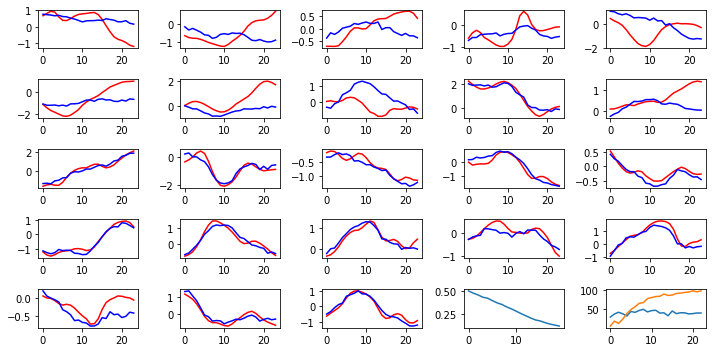

Step: 0, Train Loss: 0.13008788228034973
Step: 20, Train Loss: 0.11532934010028839
Step: 40, Train Loss: 0.12122637033462524
Step: 60, Train Loss: 0.09961950778961182
Step: 80, Train Loss: 0.1290874481201172
Step: 100, Train Loss: 0.10080205649137497
Step: 120, Train Loss: 0.10799410194158554
Step: 140, Train Loss: 0.10799813270568848
Epoch: 24, Train loss: 0.11068433912531023
acskill_socre:47.961777825262295, rmse_score:16.92439701419666
acskill_socre:103.15481125901925, rmse_score:6.152393907168785
Epoch: 24, Valid Score: 31.037380811065635, Valid Score 2: 97.00241735185047



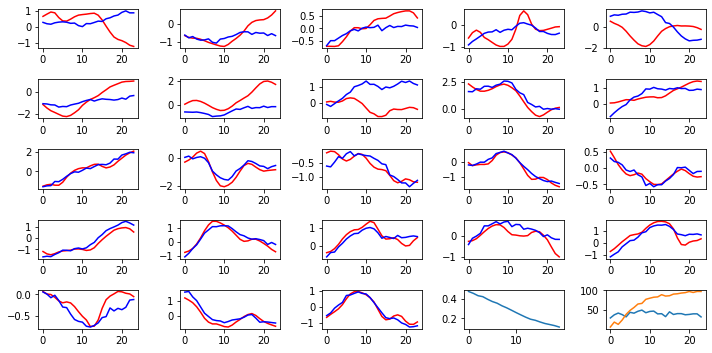

Step: 0, Train Loss: 0.13992883265018463
Step: 20, Train Loss: 0.09542560577392578
Step: 40, Train Loss: 0.09155645966529846
Step: 60, Train Loss: 0.11316293478012085
Step: 80, Train Loss: 0.10868681967258453
Step: 100, Train Loss: 0.08116193860769272
Step: 120, Train Loss: 0.12875324487686157
Step: 140, Train Loss: 0.1072082445025444
Epoch: 25, Train loss: 0.10825119105077559
acskill_socre:52.67254120912339, rmse_score:16.00849139942894
acskill_socre:102.91863196203153, rmse_score:6.129533494457096
Epoch: 25, Valid Score: 36.66404980969445, Valid Score 2: 96.78909846757443



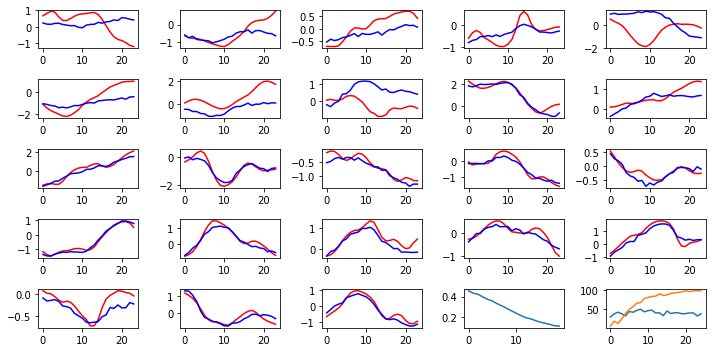

Step: 0, Train Loss: 0.11235441267490387
Step: 20, Train Loss: 0.14358118176460266
Step: 40, Train Loss: 0.09210097789764404
Step: 60, Train Loss: 0.07099127769470215
Step: 80, Train Loss: 0.09781868755817413
Step: 100, Train Loss: 0.10479643195867538
Step: 120, Train Loss: 0.09886527061462402
Step: 140, Train Loss: 0.12644410133361816
Epoch: 26, Train loss: 0.10391987326645082
acskill_socre:50.11919187539384, rmse_score:17.290214472039008
acskill_socre:103.66573026645632, rmse_score:6.289410501416262
Epoch: 26, Valid Score: 32.82897740335483, Valid Score 2: 97.37631976504007



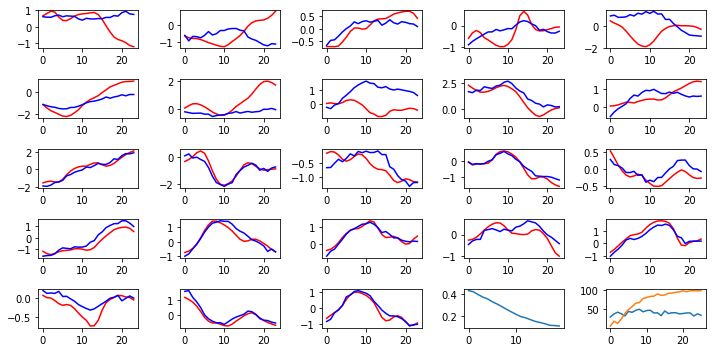

Step: 0, Train Loss: 0.12370938062667847
Step: 20, Train Loss: 0.10674645006656647
Step: 40, Train Loss: 0.0905514806509018
Step: 60, Train Loss: 0.11290548741817474
Step: 80, Train Loss: 0.0858888179063797
Step: 100, Train Loss: 0.08731944859027863
Step: 120, Train Loss: 0.09119783341884613
Step: 140, Train Loss: 0.08145646750926971
Epoch: 27, Train loss: 0.0994943704816603
acskill_socre:55.63611775575366, rmse_score:16.434199714582128
acskill_socre:103.36323875452958, rmse_score:6.249687595070463
Epoch: 27, Valid Score: 39.20191804117153, Valid Score 2: 97.1135511594591



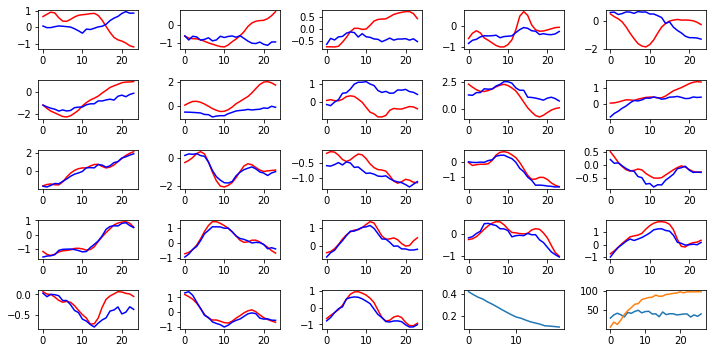

Step: 0, Train Loss: 0.10868287086486816
Step: 20, Train Loss: 0.138654887676239
Step: 40, Train Loss: 0.09487134218215942
Step: 60, Train Loss: 0.07865149527788162
Step: 80, Train Loss: 0.10804073512554169
Step: 100, Train Loss: 0.09433889389038086
Step: 120, Train Loss: 0.07822981476783752
Step: 140, Train Loss: 0.07606709003448486
Epoch: 28, Train loss: 0.08930647531824727
acskill_socre:52.78225015910272, rmse_score:16.13416671517916
acskill_socre:104.8097176763078, rmse_score:5.297679594235653
Epoch: 28, Valid Score: 36.64808344392357, Valid Score 2: 99.51203808207214



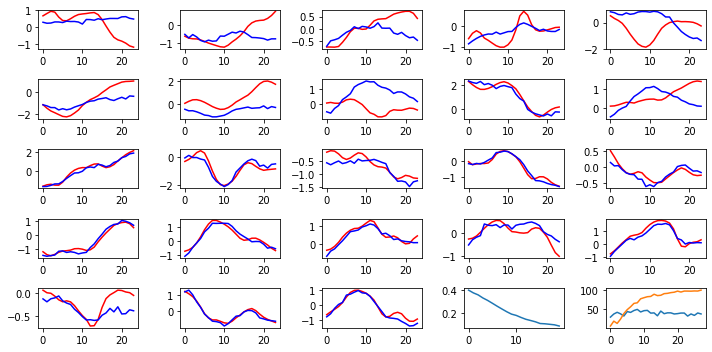

Step: 0, Train Loss: 0.098841592669487
Step: 20, Train Loss: 0.0782371386885643
Step: 40, Train Loss: 0.07291470468044281
Step: 60, Train Loss: 0.10801832377910614
Step: 80, Train Loss: 0.0906284749507904
Step: 100, Train Loss: 0.08656591176986694
Step: 120, Train Loss: 0.08454558253288269
Step: 140, Train Loss: 0.05869907885789871
Epoch: 29, Train loss: 0.08480619845851775
acskill_socre:51.365392205346154, rmse_score:16.644412193608343
acskill_socre:104.6753365201298, rmse_score:5.16509755357309
Epoch: 29, Valid Score: 34.72098001173781, Valid Score 2: 99.51023896655671



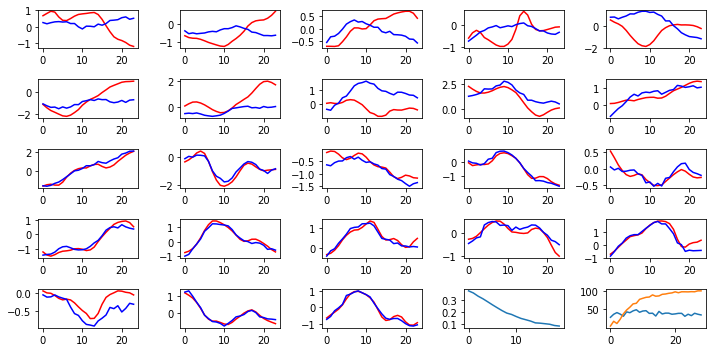

Step: 0, Train Loss: 0.07448670268058777
Step: 20, Train Loss: 0.07125332951545715
Step: 40, Train Loss: 0.09116723388433456
Step: 60, Train Loss: 0.09041871130466461
Step: 80, Train Loss: 0.06347865611314774
Step: 100, Train Loss: 0.06664928793907166
Step: 120, Train Loss: 0.0877155214548111
Step: 140, Train Loss: 0.09222280979156494
Epoch: 30, Train loss: 0.08265214745075472
acskill_socre:51.98645294533597, rmse_score:16.760335555424714
acskill_socre:105.25286456568924, rmse_score:4.761131806396882
Epoch: 30, Valid Score: 35.22611738991125, Valid Score 2: 100.49173275929235



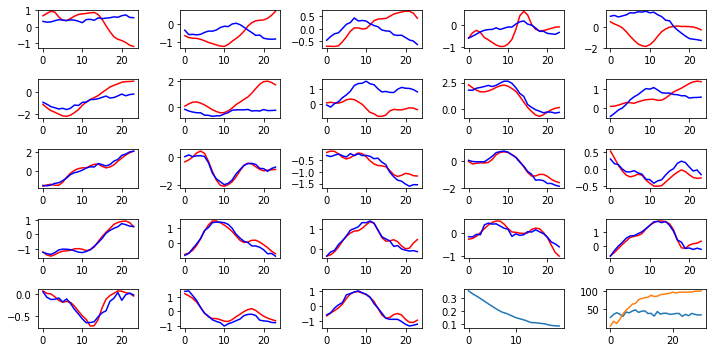

Step: 0, Train Loss: 0.06739266961812973
Step: 20, Train Loss: 0.06895242631435394
Step: 40, Train Loss: 0.07356242090463638
Step: 60, Train Loss: 0.060669660568237305
Step: 80, Train Loss: 0.07672975957393646
Step: 100, Train Loss: 0.09825187921524048
Step: 120, Train Loss: 0.08751034736633301
Step: 140, Train Loss: 0.08078590035438538
Epoch: 31, Train loss: 0.0795221958669924
acskill_socre:50.51028585504787, rmse_score:16.31011010354523
acskill_socre:105.493921819842, rmse_score:4.595915191060876
Epoch: 31, Valid Score: 34.20017575150264, Valid Score 2: 100.89800662878112



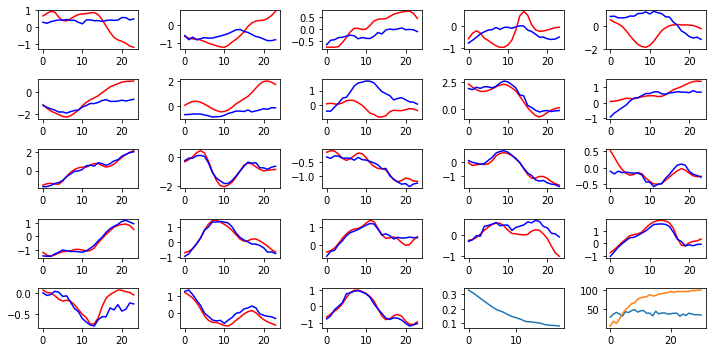

Step: 0, Train Loss: 0.06396402418613434
Step: 20, Train Loss: 0.07303649187088013
Step: 40, Train Loss: 0.06344360113143921
Step: 60, Train Loss: 0.0737534910440445
Step: 80, Train Loss: 0.08448807895183563
Step: 100, Train Loss: 0.07982122898101807
Step: 120, Train Loss: 0.06194838136434555
Step: 140, Train Loss: 0.09621705859899521
Epoch: 32, Train loss: 0.07266898599843825
acskill_socre:53.88288676339852, rmse_score:16.47655151378911
acskill_socre:104.78077065013605, rmse_score:5.642307566652793
Epoch: 32, Valid Score: 37.406335249609405, Valid Score 2: 99.13846308348326



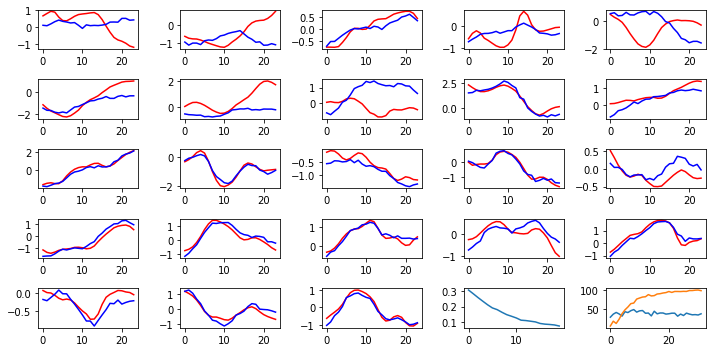

Step: 0, Train Loss: 0.06215085834264755
Step: 20, Train Loss: 0.07630007714033127
Step: 40, Train Loss: 0.06405813992023468
Step: 60, Train Loss: 0.06276825070381165
Step: 80, Train Loss: 0.05507525056600571
Step: 100, Train Loss: 0.07560020685195923
Step: 120, Train Loss: 0.06908504664897919
Step: 140, Train Loss: 0.06551847606897354
Epoch: 33, Train loss: 0.07250799760222434
acskill_socre:46.883306582712066, rmse_score:17.744465323059906
acskill_socre:105.62359261582301, rmse_score:4.722136597412547
Epoch: 33, Valid Score: 29.13884125965216, Valid Score 2: 100.90145601841047



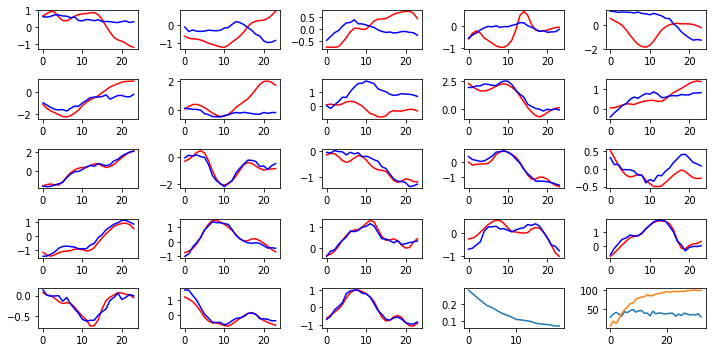

Step: 0, Train Loss: 0.06756868213415146
Step: 20, Train Loss: 0.07644503563642502
Step: 40, Train Loss: 0.07945948094129562
Step: 60, Train Loss: 0.058271005749702454
Step: 80, Train Loss: 0.07625925540924072
Step: 100, Train Loss: 0.07084400951862335
Step: 120, Train Loss: 0.0877264067530632
Step: 140, Train Loss: 0.059944599866867065
Epoch: 34, Train loss: 0.06950097634427009
acskill_socre:50.23885753093041, rmse_score:16.093629379532562
acskill_socre:105.49433740473236, rmse_score:5.088628378995777
Epoch: 34, Valid Score: 34.145228151397845, Valid Score 2: 100.40570902573658



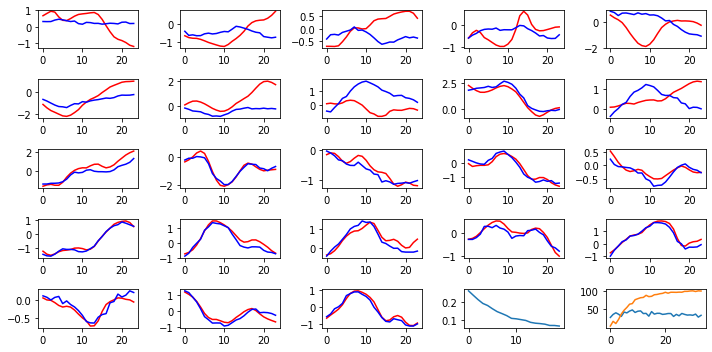

Step: 0, Train Loss: 0.06107240915298462
Step: 20, Train Loss: 0.07335709780454636
Step: 40, Train Loss: 0.061218421906232834
Step: 60, Train Loss: 0.06848207116127014
Step: 80, Train Loss: 0.06580258905887604
Step: 100, Train Loss: 0.058637090027332306
Step: 120, Train Loss: 0.06378182023763657
Step: 140, Train Loss: 0.06417413800954819
Epoch: 35, Train loss: 0.06824751736656312
acskill_socre:53.36755333909963, rmse_score:15.933840799217737
acskill_socre:105.41188792667327, rmse_score:4.915025572358186
Epoch: 35, Valid Score: 37.433712539881896, Valid Score 2: 100.49686235431508



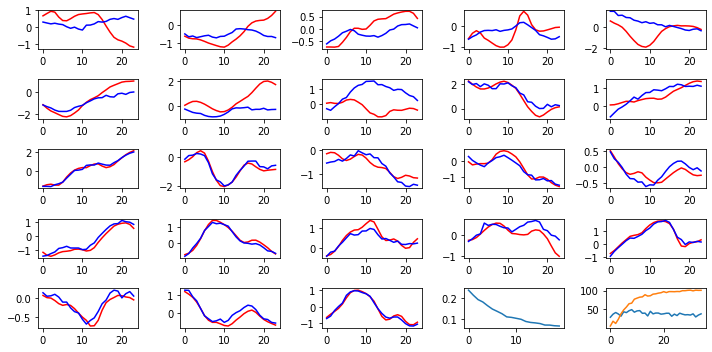

Step: 0, Train Loss: 0.07174818962812424
Step: 20, Train Loss: 0.04899777099490166
Step: 40, Train Loss: 0.07422640919685364
Step: 60, Train Loss: 0.05876976251602173
Step: 80, Train Loss: 0.07222849130630493
Step: 100, Train Loss: 0.05936190113425255
Step: 120, Train Loss: 0.06165051460266113
Step: 140, Train Loss: 0.07688133418560028
Epoch: 36, Train loss: 0.06508892147291091
acskill_socre:47.066049366440154, rmse_score:17.761116960584708
acskill_socre:105.21518213717638, rmse_score:4.906583975017508
Epoch: 36, Valid Score: 29.304932405855446, Valid Score 2: 100.30859816215887



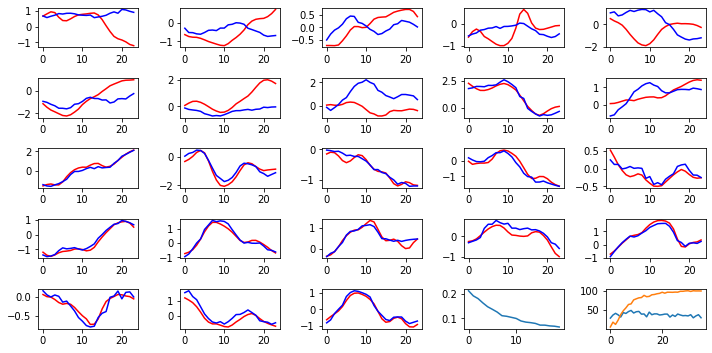

Step: 0, Train Loss: 0.046342819929122925
Step: 20, Train Loss: 0.07473419606685638
Step: 40, Train Loss: 0.0491764210164547
Step: 60, Train Loss: 0.04970851540565491
Step: 80, Train Loss: 0.04974692314863205
Step: 100, Train Loss: 0.07261955738067627
Step: 120, Train Loss: 0.07944312691688538
Step: 140, Train Loss: 0.05411083623766899
Epoch: 37, Train loss: 0.06434249130468214
acskill_socre:53.17686772709402, rmse_score:16.167146083411478
acskill_socre:105.83105699685075, rmse_score:4.57347436063876
Epoch: 37, Valid Score: 37.00972164368254, Valid Score 2: 101.25758263621199



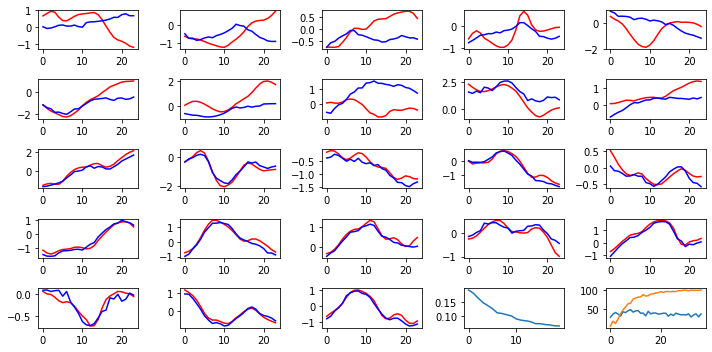

Step: 0, Train Loss: 0.0702744796872139
Step: 20, Train Loss: 0.06090135872364044
Step: 40, Train Loss: 0.06156467646360397
Step: 60, Train Loss: 0.06044363975524902
Step: 80, Train Loss: 0.05956485867500305
Step: 100, Train Loss: 0.05804513022303581
Step: 120, Train Loss: 0.07020696997642517
Step: 140, Train Loss: 0.06935994327068329
Epoch: 38, Train loss: 0.060806509419795006
acskill_socre:48.592101908146745, rmse_score:16.392363933088685
acskill_socre:105.8958387766087, rmse_score:4.550817836363996
Epoch: 38, Valid Score: 32.199737975058056, Valid Score 2: 101.34502094024471



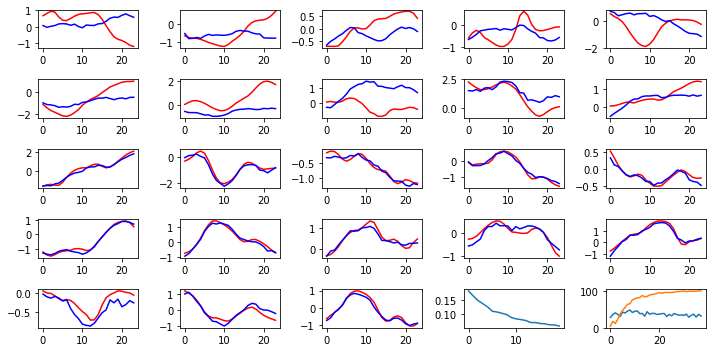

Step: 0, Train Loss: 0.05373718589544296
Step: 20, Train Loss: 0.08822029829025269
Step: 40, Train Loss: 0.07140856236219406
Step: 60, Train Loss: 0.07491971552371979
Step: 80, Train Loss: 0.0514579676091671
Step: 100, Train Loss: 0.05458376556634903
Step: 120, Train Loss: 0.045066505670547485
Step: 140, Train Loss: 0.0703008770942688
Epoch: 39, Train loss: 0.06028858937563435
acskill_socre:50.64983619261447, rmse_score:16.158762750926574
acskill_socre:106.24690303248659, rmse_score:4.42128317823933
Epoch: 39, Valid Score: 34.4910734416879, Valid Score 2: 101.82561985424725



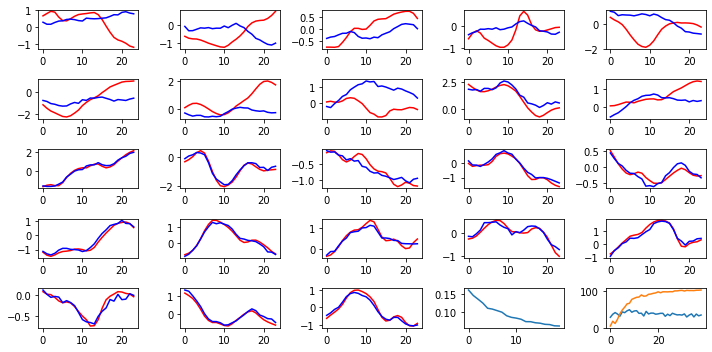

Step: 0, Train Loss: 0.055848799645900726
Step: 20, Train Loss: 0.0443168506026268
Step: 40, Train Loss: 0.05985625088214874
Step: 60, Train Loss: 0.05077224224805832
Step: 80, Train Loss: 0.061560750007629395
Step: 100, Train Loss: 0.05183332413434982
Step: 120, Train Loss: 0.048604827374219894
Step: 140, Train Loss: 0.06145132705569267
Epoch: 40, Train loss: 0.057461822321338035
acskill_socre:48.248510740990795, rmse_score:17.047431496257527
acskill_socre:106.33222553723728, rmse_score:4.093129314734221
Epoch: 40, Valid Score: 31.20107924473327, Valid Score 2: 102.23909622250305



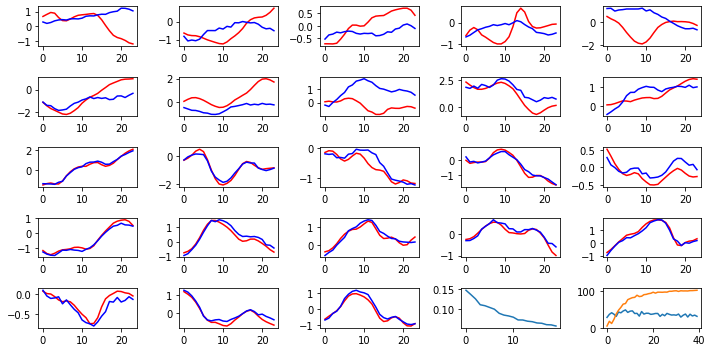

Step: 0, Train Loss: 0.04321619123220444
Step: 20, Train Loss: 0.07156868278980255
Step: 40, Train Loss: 0.048105984926223755
Step: 60, Train Loss: 0.05529861897230148
Step: 80, Train Loss: 0.04619145393371582
Step: 100, Train Loss: 0.04516390711069107
Step: 120, Train Loss: 0.0528489351272583
Step: 140, Train Loss: 0.07693290710449219
Epoch: 41, Train loss: 0.054731871548198884
acskill_socre:50.18934892943044, rmse_score:16.219137731809106
acskill_socre:106.55040393802676, rmse_score:4.221777679063075
Epoch: 41, Valid Score: 33.97021119762133, Valid Score 2: 102.32862625896368



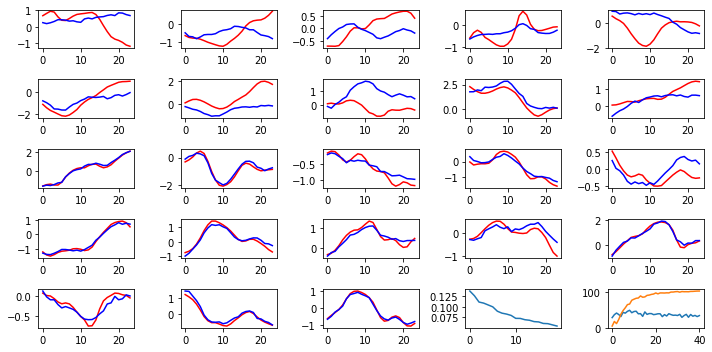

Step: 0, Train Loss: 0.059391580522060394
Step: 20, Train Loss: 0.04750174283981323
Step: 40, Train Loss: 0.051832132041454315
Step: 60, Train Loss: 0.05770915001630783
Step: 80, Train Loss: 0.03961844742298126
Step: 100, Train Loss: 0.0452815517783165
Step: 120, Train Loss: 0.046259041875600815
Step: 140, Train Loss: 0.06361208111047745
Epoch: 42, Train loss: 0.053287934776275386
acskill_socre:53.53710157031589, rmse_score:16.25778248905973
acskill_socre:106.74086044570602, rmse_score:4.517101475184743
Epoch: 42, Valid Score: 37.27931908125616, Valid Score 2: 102.22375897052127



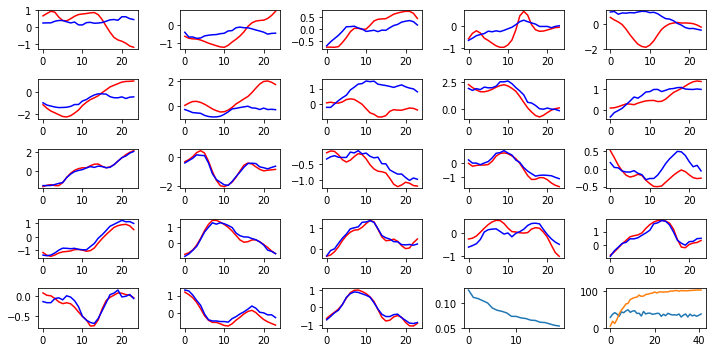

Step: 0, Train Loss: 0.04126222804188728
Step: 20, Train Loss: 0.049271147698163986
Step: 40, Train Loss: 0.045148056000471115
Step: 60, Train Loss: 0.04585748910903931
Step: 80, Train Loss: 0.06926572322845459
Step: 100, Train Loss: 0.048099614679813385
Step: 120, Train Loss: 0.05255691334605217
Step: 140, Train Loss: 0.05186498910188675
Epoch: 43, Train loss: 0.05057410004158174
acskill_socre:48.45034395604043, rmse_score:16.427300852757234
acskill_socre:106.37699723643307, rmse_score:4.260830542927283
Epoch: 43, Valid Score: 32.02304310328319, Valid Score 2: 102.11616669350579



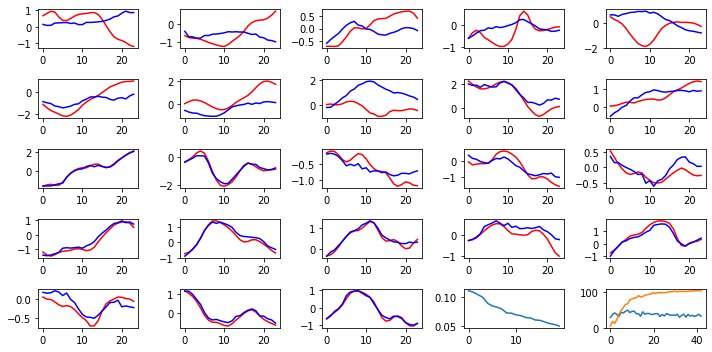

Step: 0, Train Loss: 0.055628709495067596
Step: 20, Train Loss: 0.05444201081991196
Step: 40, Train Loss: 0.044041961431503296
Step: 60, Train Loss: 0.04548060894012451
Step: 80, Train Loss: 0.04670378193259239


In [ ]:
train(num_epochs=50)

In [ ]:
# model.load_state_dict(torch.load('models/basemodel_best.pt'))

In [ ]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [ ]:
### 2. predict
test_predicts_dict = {}
for file_name, val in test_feas_dict.items():
    SST = np.expand_dims(val[:,:,:,0],axis=0)
    T300 = np.expand_dims(val[:,:,:,1],axis=0)
    Ua = np.expand_dims(val[:,:,:,2],axis=0)
    Va = np.expand_dims(val[:,:,:,3],axis=0)
    
    SST = np.nan_to_num(SST) # trans nan to 0
    T300 = np.nan_to_num(T300)
    Ua = np.nan_to_num(Ua)
    Va = np.nan_to_num(Va)
    
#     data_list = [SST,T300,Ua,Va]
#     SST,T300,Ua,Va = fit_data(data_list, fit=False)

    SST = torch.tensor(SST).to(device).float()
    T300 = torch.tensor(T300).to(device).float()
    Ua = torch.tensor(Ua).to(device).float()
    Va = torch.tensor(Va).to(device).float()
    
    result = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
    test_predicts_dict[file_name] = result

In [ ]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [ ]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [ ]:
make_zip()